# LSTM Modeling

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import os
import keras

os.environ["KERAS_BACKEND"] = "torch"

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")
    
torch.mps.set_per_process_memory_fraction(0.0)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

import sys
sys.path.append('../src')  
import utils as util

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
tensor([1.], device='mps:0')
utils OK


## Load Configuration File

In [2]:
config = util.load_config()

## Read Data

In [3]:
# hyperparameter
ls_bs = [2, 4, 6]
ls_epoch = [10, 25, 50]
ls_lr = [0.001, 0.0001, 0.00001]

batch_size=4
num_epochs=30
learning_rate=0.0001

In [4]:
target = ['pm1', 'pm25', 'pm10', 'co']

target_col = 'co'
sensor_data = 'sensor_data_3'

data_path_pkl = '../' + config['train_test_data']['directory'] + config['train_test_data']['file_name_pkl']  

df = util.load_data_pickle(data_path_pkl)
df = df[sensor_data][[target_col]]

df.head()

,co
datetime,
2024-07-02 15:00:00,19.543611
2024-07-02 16:00:00,8.535421
2024-07-02 17:00:00,7.682224
2024-07-02 18:00:00,7.767747
2024-07-02 19:00:00,8.094099


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2024-07-02 15:00:00 to 2024-07-13 04:00:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co      254 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


## Preprocessing

### Splitting Data

In [6]:
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train_data, test_data = df[:train_size], df[train_size:]

In [7]:
dataset_train = train_data[target_col].values
dataset_train = np.reshape(dataset_train, (-1,1))

dataset_test = test_data[target_col].values
dataset_test = np.reshape(dataset_test, (-1,1))

### Normalization

In [8]:
scaler = StandardScaler()

scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)

### Create Time Series Dataset

In [9]:
time_step_train = 20
time_step_test = 15

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i+time_step])
        Y.append(dataset[i+1:i+time_step+1])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(scaled_train, time_step_train)
X_test, y_test = create_dataset(scaled_test, time_step_test)

In [10]:
X_train.shape, y_train.shape

((157, 20, 1), (157, 20, 1))

In [11]:
X_test.shape, y_test.shape

((62, 15, 1), (62, 15, 1))

### Convert to Tensor

In [12]:
X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test).float().to(device)

In [13]:
# batch_size = 4
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Modeling

In [14]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): 
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [15]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

def rmse_loss(output, target):
    mse = nn.MSELoss(reduction='mean')
    return torch.sqrt(mse(output, target))

model = LSTMModel(input_size, hidden_size, num_layers).to(device)
# loss_fn = torch.nn.MSELoss(reduction='mean')
loss_fn = rmse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
train_hist =[]
test_hist =[]

for epoch in range(num_epochs):
    total_loss = 0.0
    
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_loss += loss.item()
    
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)
 
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
 
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)
 
            total_test_loss += test_loss.item()
    
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
        
    if (epoch+1)%5==0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [5/30] - Training Loss: 0.5291, Test Loss: 0.8430
Epoch [10/30] - Training Loss: 0.4160, Test Loss: 0.8330
Epoch [15/30] - Training Loss: 0.3836, Test Loss: 0.8164
Epoch [20/30] - Training Loss: 0.3582, Test Loss: 0.7839
Epoch [25/30] - Training Loss: 0.3344, Test Loss: 0.7290
Epoch [30/30] - Training Loss: 0.2908, Test Loss: 0.6303


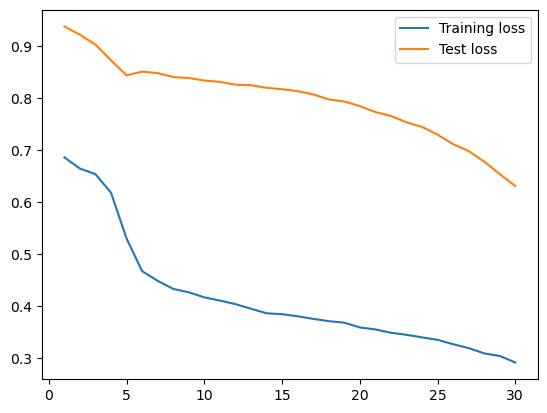

In [17]:
x = np.linspace(1, num_epochs, num_epochs)
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

## Prediction

In [18]:
data = df[target_col].values
data = np.reshape(data, (-1,1))
data = scaler.transform(data)
new_df = df.reset_index()
dates = new_df['datetime'].values

# prediksi 24 jam = 1 hari
seq_length = 24
sequences = []
for i in range(len(data) - seq_length):
    sequences.append(data[i:i+seq_length])
sequences = np.array(sequences)
sequences = torch.tensor(sequences).float().to(device)

model.eval()
with torch.no_grad():
    prediction = model(sequences).cpu().numpy()
prediction = scaler.inverse_transform(np.squeeze(prediction))
prediction = prediction[0]

In [19]:
prediction

array([10.037279 ,  9.758861 ,  8.966154 ,  8.328505 ,  8.079195 ,
        8.094455 ,  8.166944 ,  8.194129 ,  8.173763 ,  8.156602 ,
        8.159483 ,  8.191316 ,  8.210253 ,  8.239101 ,  8.267105 ,
        8.272771 ,  8.351409 ,  8.246666 ,  8.070118 ,  7.950744 ,
        7.8986115,  7.873171 ,  7.8732405,  7.878158 ], dtype=float32)

### Plotting Prediction Result

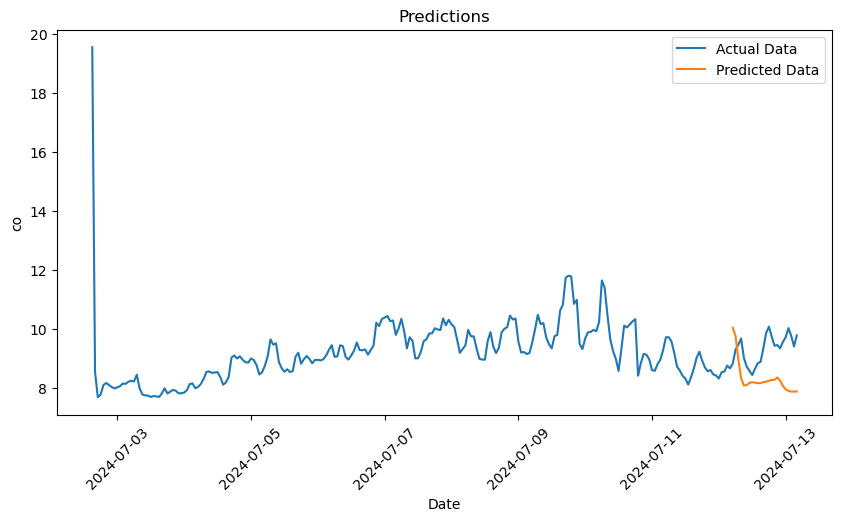

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(dates, df[target_col].values, label='Actual Data')
plt.plot(dates[len(dates) - len(prediction):], prediction, label='Predicted Data')
plt.title(f'Predictions')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Root Mean Squared Error (RMSE)

In [21]:
def rmse_calculate(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

In [22]:
rmse = rmse_calculate(df[target_col][:24].values, prediction)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1.9818457778192313


### Save Model

In [23]:
torch.save(model.state_dict(), f'../models/{sensor_data}_{target_col}_lstm_model.pth')